In [1]:
"""Preprocesses data for training.

Preferrably, run using Jupyter Notebook.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [2]:
# Read raw data from the excel file.
raw_data = pd.read_excel(
    "data/ouse93-96-raw-data.xlsx",
    index_col=0,
    header=1,
    usecols='A:I'
)

In [3]:
# Convert columns to float values. Turn non-numeric values into np.nan.
for column in raw_data.columns[1:]:
    raw_data[column] = pd.to_numeric(raw_data[column], errors='coerce')

In [4]:
# Convert negative values into np.nan.
raw_data = raw_data.mask(raw_data < 0, np.nan)

In [5]:
# Print all rows with NAN values.
raw_data[raw_data.isna().any(axis=1)]

,Crakehill,Skip Bridge,Westwick,Skelton,Arkengarthdale,East Cowton,Malham Tarn,Snaizeholme
1993-02-13,NaN,5.476,11.051,30.73,0.0,0.0,0.0,0.0
1993-03-15,NaN,2.546,7.179,18.06,11.2,0.0,86.0,19.2
1993-03-16,NaN,2.494,7.232,17.16,0.8,0.0,12.8,8.0
1993-04-07,22.90,4.159,26.603,NaN,2.4,0.0,0.0,3.2
1993-04-27,24.40,11.684,22.181,73.96,NaN,0.0,0.0,0.0
1995-03-01,80.60,19.096,100.761,174.00,17.6,NaN,51.2,21.6
1996-02-09,12.70,NaN,7.576,20.58,0.0,37.6,12.0,14.4
1996-04-18,7.61,NaN,13.918,16.84,0.8,4.8,47.2,32.0


In [6]:
# Calculate mean and standard deviation for each numeric column.
standard_deviations = raw_data.std()
means = raw_data.mean()

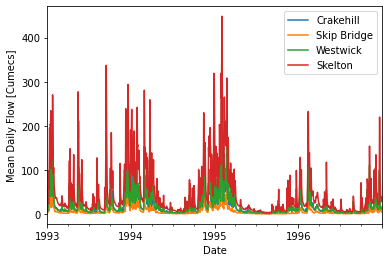

In [7]:
# Plot river flow columns.
raw_data[['Crakehill', 'Skip Bridge', 'Westwick', 'Skelton']].plot(xlabel="Date", ylabel="Mean Daily Flow [Cumecs]")
plt.savefig('figures/river-flow.png') 

In [8]:
# Find the values that lies the furthest from the mean from Mean Daily Flow columns.
skelton_max = raw_data['Skelton'].max()
print(raw_data['Skelton'].sort_values(ascending=False).head())
print((skelton_max - means['Skelton']) / standard_deviations['Skelton'])


1995-02-01    448.1
1995-02-02    362.3
1993-09-15    337.2
1995-01-29    319.6
1994-12-29    319.1
Name: Skelton, dtype: float64
7.197730720717447


1995-02-11    5000.0
Name: Arkengarthdale, dtype: float64
1995-02-28    9000.0
Name: East Cowton, dtype: float64
1996-01-10    80000.0
Name: Malham Tarn, dtype: float64


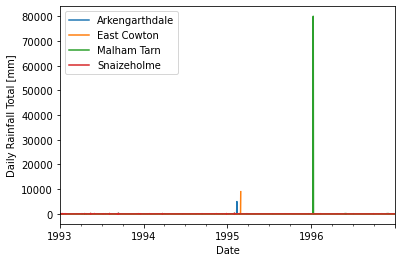

In [9]:
# Plot river flow columns.
raw_data[['Arkengarthdale', 'East Cowton', 'Malham Tarn', 'Snaizeholme']].plot(xlabel="Date", ylabel="Daily Rainfall Total [mm]")
plt.savefig('figures/rainfall.png')

print(raw_data['Arkengarthdale'].sort_values(ascending=False).head(1))
print(raw_data['East Cowton'].sort_values(ascending=False).head(1))
print(raw_data['Malham Tarn'].sort_values(ascending=False).head(1))

In [10]:
# Interpolate outliers.
for column in raw_data[['Arkengarthdale', 'East Cowton', 'Malham Tarn']].columns:
    column_values = raw_data[column]
    column_max_id = column_values.idxmax()
    column_values.loc[column_max_id] = np.nan

    """
    column_values = column_values.mask(
        column_values > means[column] + 3 * standard_deviations[column],
        np.nan
    )
    
    # If this is a river flow column, check the lower bound as well.
    if column in ['Crakehill', 'Skip Bridge', 'Westwick', 'Skelton']:
        column_values = column_values.mask(
            column_values < means[column] - 3 * standard_deviations[column],
            np.nan
        )
    raw_data[column] = column_values.interpolate(method="linear") 
    """

In [11]:
# Imputate spurious data.
raw_data = raw_data.interpolate(method="linear")

In [12]:
# Print all rows with NAN values.
raw_data[raw_data.isna().any(axis=1)]

,Crakehill,Skip Bridge,Westwick,Skelton,Arkengarthdale,East Cowton,Malham Tarn,Snaizeholme


In [13]:
# Print values interpolated for outliers.
print(raw_data.loc["1995-02-11", "Arkengarthdale"])
print(raw_data.loc["1995-02-28", "East Cowton"])
print(raw_data.loc["1996-01-10", "Malham Tarn"])


15.6
0.0
4.4


In [14]:
# Print all rows with NAN values.
raw_data[raw_data.isna().any(axis=1)]

,Crakehill,Skip Bridge,Westwick,Skelton,Arkengarthdale,East Cowton,Malham Tarn,Snaizeholme


In [15]:
# Add a column for Mean Daily Flow in Skelton one day before. 
raw_data.insert(0, 'Skelton T-1', raw_data['Skelton'])

In [16]:
# Make predictand column the rightmost column.
columns = raw_data.columns
skelton_column = raw_data.pop("Skelton")
raw_data.insert(len(columns) - 1, skelton_column.name, skelton_column)

In [17]:
# Explore moving average

#weights = np.array([0.5, 0.25, 0.25])
#sum_weights = np.sum(weights)

raw_data.insert(0, "Skelton MA", raw_data['Skelton T-1'].rolling(3).mean())
raw_data.insert(0, "Arkengarthdale MA", raw_data['Arkengarthdale'].rolling(3).mean())
raw_data.insert(0, "East Cowton MA", raw_data['East Cowton'].rolling(3).mean())
raw_data.insert(0, "Malham Tarn MA", raw_data['Malham Tarn'].rolling(3).mean())
raw_data.insert(0, "Snaizeholme MA", raw_data['Snaizeholme'].rolling(3).mean())
raw_data["Snaizeholme MA"]["1993-01-01"]

nan

In [18]:
# Explore the correlations between potential predictors and the predictand.

print(raw_data.corr()["Skelton"].sort_values(ascending=False))
# Lag Mean Daily Flow potential predictor columns by one day.
raw_data["Skelton MA"] = raw_data['Skelton MA'].shift(periods=1, freq="D")
raw_data['Skelton T-1'] = raw_data['Skelton T-1'].shift(periods=1, freq="D")
raw_data['Crakehill'] = raw_data['Crakehill'].shift(periods=1, freq="D")
raw_data['Skip Bridge'] = raw_data['Skip Bridge'].shift(periods=1, freq="D")
raw_data['Westwick'] = raw_data['Westwick'].shift(periods=1, freq="D")

# Lag Rainfall columns by one day.
raw_data['Arkengarthdale MA'] = raw_data['Arkengarthdale MA'].shift(periods=1, freq="D")
raw_data['East Cowton MA'] = raw_data['East Cowton MA'].shift(periods=1, freq="D")
raw_data['Malham Tarn MA'] = raw_data['Malham Tarn MA'].shift(periods=1, freq="D")
raw_data['Snaizeholme MA'] = raw_data['Snaizeholme MA'].shift(periods=1, freq="D")
raw_data['Arkengarthdale'] = raw_data['Arkengarthdale'].shift(periods=1, freq="D")
raw_data['East Cowton'] = raw_data['East Cowton'].shift(periods=1, freq="D")
raw_data['Malham Tarn'] = raw_data['Malham Tarn'].shift(periods=1, freq="D")
raw_data['Snaizeholme'] = raw_data['Snaizeholme'].shift(periods=1, freq="D")

correlations = raw_data.corr()
correlations["Skelton"].sort_values(ascending=False)

Skelton T-1          1.000000
Skelton              1.000000
Crakehill            0.972963
Skip Bridge          0.947450
Skelton MA           0.929755
Westwick             0.886928
Snaizeholme MA       0.668919
Arkengarthdale MA    0.587650
Malham Tarn MA       0.568044
East Cowton MA       0.396614
Snaizeholme          0.345434
Arkengarthdale       0.297903
Malham Tarn          0.293830
East Cowton          0.181339
Name: Skelton, dtype: float64


Skelton              1.000000
Westwick             0.912792
Skelton T-1          0.889158
Crakehill            0.885093
Skip Bridge          0.884202
Skelton MA           0.811185
Snaizeholme MA       0.689903
Arkengarthdale MA    0.594483
Malham Tarn MA       0.586907
Snaizeholme          0.584831
Arkengarthdale       0.507064
Malham Tarn          0.495231
East Cowton MA       0.402025
East Cowton          0.338331
Name: Skelton, dtype: float64

In [19]:
# Drop rows containing missing values after lagging.
raw_data = raw_data.dropna()
raw_data

,Snaizeholme MA,Malham Tarn MA,East Cowton MA,Arkengarthdale MA,Skelton MA,Skelton T-1,Crakehill,Skip Bridge,Westwick,Arkengarthdale,East Cowton,Malham Tarn,Snaizeholme,Skelton
1993-01-04,1.333333,0.533333,0.000000,0.000000,24.853333,23.60,9.46,4.124,8.057,0.0,0.0,0.8,0.0,23.47
1993-01-05,20.533333,0.800000,8.266667,0.800000,23.976667,23.47,9.41,4.363,7.925,2.4,24.8,0.8,61.6,60.70
1993-01-06,57.600000,11.733333,10.133333,4.533333,35.923333,60.70,26.30,11.962,58.704,11.2,5.6,33.6,111.2,98.01
1993-01-07,57.866667,12.000000,10.133333,4.533333,60.726667,98.01,32.10,10.237,34.416,0.0,0.0,1.6,0.8,56.99
1993-01-08,49.333333,17.600000,3.200000,5.600000,71.900000,56.99,19.30,7.254,22.263,5.6,4.0,17.6,36.0,56.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996-12-27,0.533333,0.266667,1.333333,0.000000,39.763333,33.06,11.70,6.075,12.671,0.0,0.8,0.0,0.0,29.52
1996-12-28,1.600000,3.200000,6.133333,0.533333,34.110000,29.52,10.90,5.721,11.558,1.6,14.4,8.8,3.2,28.67
1996-12-29,2.666667,4.533333,8.800000,4.266667,30.416667,28.67,11.10,5.486,11.411,11.2,11.2,4.8,4.8,29.31
1996-12-30,2.933333,4.533333,10.133333,5.333333,29.166667,29.31,12.10,5.329,11.781,3.2,4.8,0.0,0.8,34.28


IndexError: index 4 is out of bounds for axis 0 with size 4

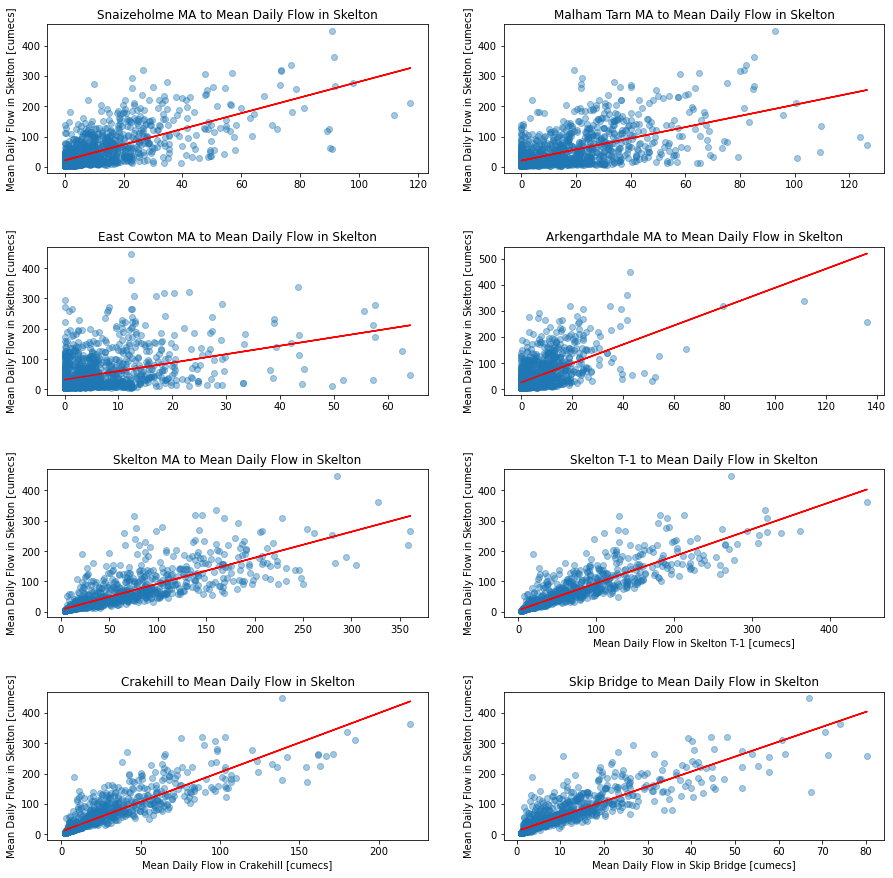

In [20]:
# Plot correlation between lagged predictors and the predictand.

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15,15))

plt.subplots_adjust(wspace=0.2, hspace=0.5)

mean_daily_flow_columns = ["Skelton T-1", "Crakehill", "Skip Bridge", "Westwick"]
daily_rainfall_total_columns = ["Arkengarthdale", "East Cowton", "Malham Tarn", "Snaizeholme"]


for i in range(len(raw_data.loc[:, raw_data.columns != "Skelton"].columns)):
    column_name = raw_data.iloc[:, i].name
    x = raw_data.iloc[:, i].values.reshape(-1, 1)
    y = raw_data['Skelton'].values.reshape(-1, 1)
    linear_regressor = LinearRegression()
    linear_regressor.fit(x, y)
    y_pred = linear_regressor.predict(x)
    axes[i // 2][ i % 2].scatter(x, y, alpha=0.4)
    axes[i // 2][ i % 2].plot(x, y_pred, color='red')
    # Decide on x-label.
    if column_name in mean_daily_flow_columns:
        axes[i // 2][ i % 2].set_xlabel(f"Mean Daily Flow in {column_name} [cumecs]")
    elif column_name in daily_rainfall_total_columns:
        axes[i // 2][ i % 2].set_xlabel(f"Daily Rainfall Total in {column_name} [mm]")
    axes[i // 2][ i % 2].set_ylabel('Mean Daily Flow in Skelton [cumecs]')
    axes[i // 2][ i % 2].set_title(f"{column_name} to Mean Daily Flow in Skelton")

plt.savefig('figures/predictors-predictand.png')
    


In [ ]:
# Split the data into into training-validation and test sets.
train_and_validation, test = train_test_split(raw_data, test_size=0.2)

# Calculate min and max values from training-validation set.
max_values = train_and_validation.max(axis=0)
min_values = train_and_validation.min(axis=0)
print(max_values)
print(min_values)

# Split training-validation set into training and validation sets.
train, validation = train_test_split(train_and_validation, test_size=0.25)
train

In [ ]:
def standardise(x: pd.Series, max_value: float, min_value: float):
    """Standardises data using minimum and maximum values.
    
    Args:
    x: A pandas.Series instance.
    max_value: A maximum value for the standardisation formula.
    min_value: A minimum value for the standardisation formula.
    
    Returns:
    pandas.Series.
    """
    return 0.8 * ((x - min_value) / (max_value - min_value)) + 0.1
    
# Standardise the data.
standardised_data_sets = []
for data_set in [train, validation, test]:
    standardised_columns = []
    for column in data_set.columns:
        standardised_column = data_set.loc[:, column].apply(standardise, args=(max_values[column], min_values[column]))
        standardised_columns.append(standardised_column)
    standardised_data_set = pd.concat(standardised_columns, axis=1)
    standardised_data_sets.append(standardised_data_set)
        
train_standardised = standardised_data_sets[0]
validation_standardised = standardised_data_sets[0]
test_standardised = standardised_data_sets[0]
train_standardised